In [1]:
import numpy as np
import cvxpy as cvx

import scipy as sp
import scipy.sparse
import scipy.sparse.linalg

import sklearn
import sklearn.preprocessing

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import networkx as nx

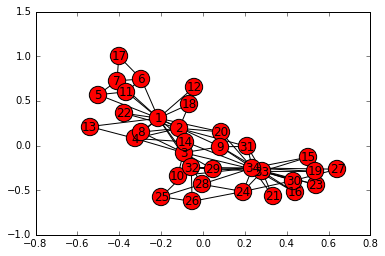

In [2]:
kn = nx.read_gml("karate.gml")
nx.draw_networkx(kn)

In [7]:
nx.degree(kn)

{u'1': 16,
 u'10': 2,
 u'11': 3,
 u'12': 1,
 u'13': 2,
 u'14': 5,
 u'15': 2,
 u'16': 2,
 u'17': 2,
 u'18': 2,
 u'19': 2,
 u'2': 9,
 u'20': 3,
 u'21': 2,
 u'22': 2,
 u'23': 2,
 u'24': 5,
 u'25': 3,
 u'26': 3,
 u'27': 2,
 u'28': 4,
 u'29': 3,
 u'3': 10,
 u'30': 4,
 u'31': 4,
 u'32': 6,
 u'33': 12,
 u'34': 17,
 u'4': 6,
 u'5': 3,
 u'6': 4,
 u'7': 4,
 u'8': 4,
 u'9': 5}

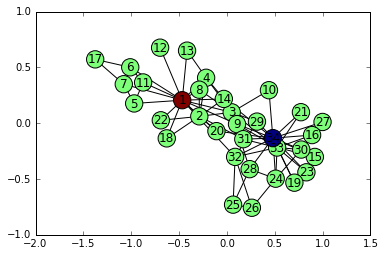

In [8]:
nodes_old = kn.nodes()
d = np.zeros(len(nodes_old))
d[nodes_old.index('1')] = 1
d[nodes_old.index('34')] = -1

nx.draw_networkx(kn, node_color=d)

In [9]:
A = nx.adjacency_matrix(kn)

In [10]:
# preprocessing

F = sklearn.preprocessing.normalize(A.astype(np.float), axis=1, norm='l1')
B = sklearn.preprocessing.normalize(A.T.astype(np.float), axis=1, norm='l1')

In [11]:
# we are looking for solution x == T(x)

def T(x):
    return a1 * F.dot(x.clip(0)) + a2 * B.dot(x.clip(-np.inf, 0)) + a3 * d

In [12]:
a1 = 0.7
a2 = 0.7
a3 = 0.7

In [13]:
# RepRank

def RepRank(maxiter=200, x0=None, tol=1e-8, callback=None):
    if x0 is None:
        x_prev = d.copy()
    else:
        x_prev = x0.copy()

    for k in range(maxiter):
        x_next = T(x_prev)
        n = np.linalg.norm(x_next - x_prev)
        if callback is not None:
            callback(x_next, n)
        if n < tol:
            break
        x_prev = x_next

    ans = x_next.copy()
    return(k + 1, ans.reshape(-1,))

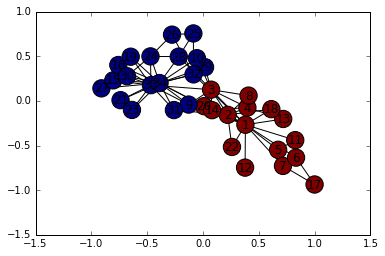

In [14]:
k, ans = RepRank()

col = ans.copy()
col[ans > 0] = 1
col[ans < 0] = -1

nx.draw_networkx(kn, node_color=col)

In [15]:
kn.add_node('s')
kn.add_edge('s', '34')
kn.add_node('t')
kn.add_edge('t', '1')

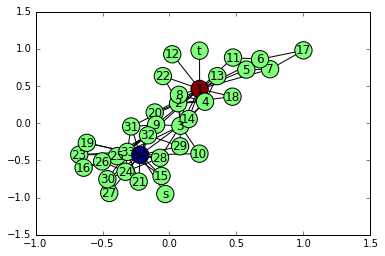

In [17]:
nodes_new = kn.nodes()
d = np.zeros(len(nodes_new))
d[nodes_new.index('1')] = 1
d[nodes_new.index('34')] = -1

nx.draw_networkx(kn, node_color=d)

In [18]:
U = nx.adjacency_matrix(kn).todense()

U[nodes_new.index('s'), :] *= 100
U[:, nodes_new.index('t')] *= 100

In [19]:
N = U.shape[0]

f = cvx.Variable(N, N)
b = cvx.Variable()

obj = cvx.Maximize(b)

constraints = [0 <= f, f <= U,
               cvx.sum_entries(f[nodes_new.index('s'), :]) - cvx.sum_entries(f[:, nodes_new.index('s')]) == b,
               cvx.sum_entries(f[:, nodes_new.index('t')]) - cvx.sum_entries(f[nodes_new.index('t'), :]) == b]

for i in range(N):
    if i != nodes_new.index('s') and i != nodes_new.index('t'):
        constraints.append(cvx.sum_entries(f[i, :], axis=1) - cvx.sum_entries(f.T[i, :], axis=1) == 0)

prob = cvx.Problem(obj, constraints)

prob.solve()

print(prob.value)

10.0000000011


In [20]:
cut = np.where( # set of cut edges
    np.logical_and(U > 1e-5, # edge should exist
                   U - np.array(f.value) < 1e-5)) # edge should be saturated

print(cut)

(matrix([[ 8,  9, 11, 11, 11, 11, 11, 17, 17, 20, 27, 28, 29, 31, 31, 31]]), matrix([[11, 11, 10, 12, 14, 18, 24, 10, 11, 11, 11, 10, 12,  4, 20, 24]]))


In [35]:
V = U.copy()

for i in range(U.shape[0]):
    for j in range(V.shape[0]):
        if U[i, j] > 1e-5 and U[i, j] - np.array(f.value)[i, j] < 1e-5:
            V[i, j] = 0

In [36]:
(V != U).sum()

16

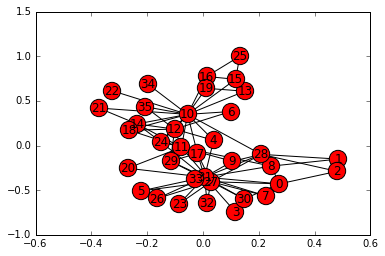

In [51]:
nx.draw_networkx(nx.from_numpy_matrix(V))

In [32]:
def h(x):
    ans = np.zeros_like(x)
    ans[x > 0.0] = 1.0
    return ans

In [33]:
def obj(x):
    return np.linalg.norm(x - T(x)) ** 2 / 2

In [34]:
def Jac(x):
    return np.eye(F.shape[0]) - a1 * np.multiply(F, h(x).reshape(-1, 1)) - a2 * np.multiply(B, h(-x).reshape(-1, 1))

In [35]:
def der(x):
    l = x - T(x)
    return Jac(x).T.dot(l)

In [36]:
def Hess(x):
    return Jac(x).T.dot(Jac(x))

In [12]:
def LineSearch(x, dx):
    alpha = obj(x) / np.linalg.norm(dx) ** 2
    while True:
        if obj(x + alpha * dx) < obj(x):
            return x + alpha * dx
        else:
            alpha /= 2

In [37]:
x_prev = d.copy()
x_next = x_prev.copy()

for k in range(100):
    dx = der(x_prev)
    #x_next = LineSearch(x_prev, -dx)
    x_next = x_prev - dx * obj(x_prev) / np.linalg.norm(dx) ** 2
    if obj(x_next) < 1e-8:
        break
    x_prev = x_next.copy()

print(k)

74


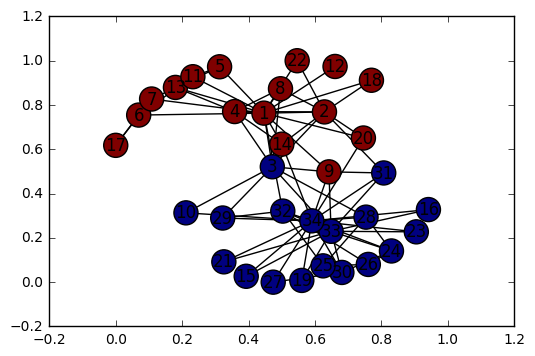

In [38]:
ans = x_prev.copy()
ans[x_prev > 0] = 1
ans[x_prev < 0] = -1

nx.draw_networkx(kn, node_color=ans)

In [39]:
x_prev = d.copy()
x_next = x_prev.copy()

for k in range(100):
    dx = np.linalg.solve(Hess(x_prev), -der(x_prev))
    x_next = x_prev + dx
    if obj(x_next) < 1e-8:
        break
    print(k, obj(x_next))
    x_prev = x_next.copy()

0 0.0284364502781
1 0.00416541912519


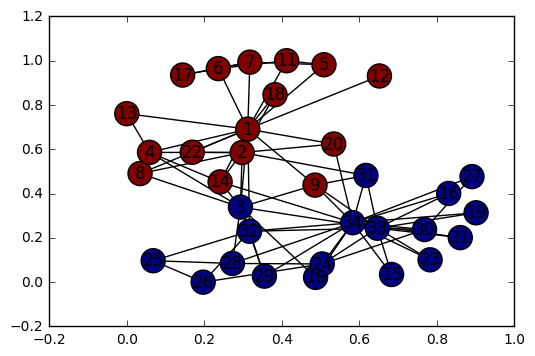

In [40]:
ans = x_prev.copy()
ans[x_prev > 0] = 1
ans[x_prev < 0] = -1

nx.draw_networkx(kn, node_color=ans)